# Preamble

In [ ]:
# Run once to allow imports
%cd ..

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import datasets
from train import get_model_class
from style import plot_grads, bold
from similarity import get_top_k, average_pairwise_score, top_k_sa

In [4]:
random_sources = ['rs', 'loo']
random_source = random_sources[0]
print(bold("Source of Randomness:"), random_source)

Source of Randomness: rs


In [5]:
name = 'heloc'  # or 'german'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
optim = 'sgd'
epochs = 20
lr = 0.1
batch_size = 64
dropout = 0
directory = f'models/{name}/{random_source}/{optim}_epochs{epochs}_lr{lr}_batch{batch_size}_dropout{dropout}'
print(bold("Directory:"), directory)

Directory: models/heloc/rs/sgd_epochs20_lr0.1_batch64_dropout0


# First Layer Weight Norms

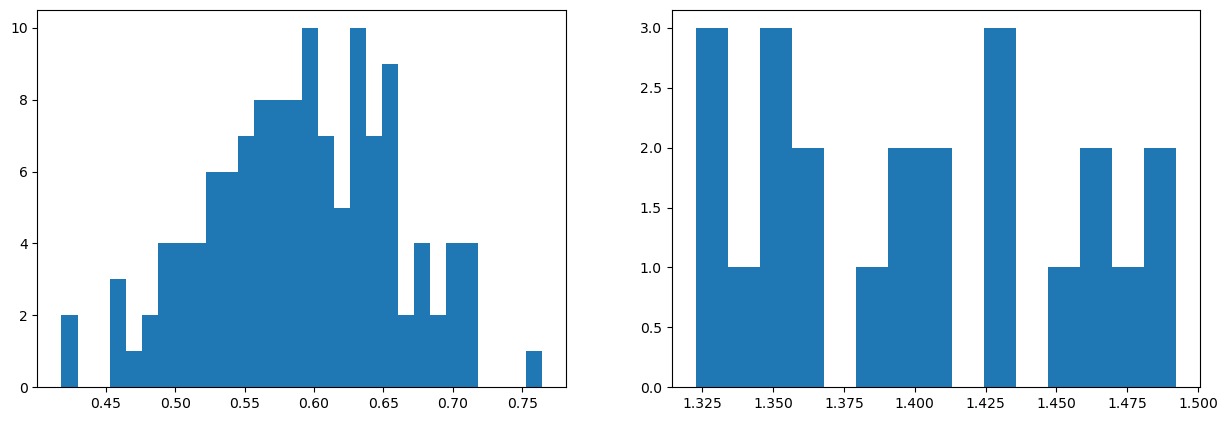

In [12]:
model_class = get_model_class(name)
model = model_class(*model_args)
state_dict = torch.load(f'{directory}/model_{0}.pth')
model.load_state_dict(state_dict)
first_layer = state_dict['network.0.weight'].numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
ax[0].hist(np.linalg.norm(first_layer, axis=1), bins=30)
ax[1].hist(np.linalg.norm(first_layer, axis=0), bins=15)
plt.show()

# One model, Gaussian noise (mean = 0, std. dev = sigma) on first layer

In [86]:
sigma = 0.5
model_idx = 0
model_class = get_model_class(name)
model = model_class(*model_args)
state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx}.pth')
model.load_state_dict(state_dict)
# Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
original_grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
original_preds = model.predict(X_test, return_numpy=True)

In [88]:
n_samples = 1000
noisy_grads = np.zeros((n_samples, *original_grads.shape))
noisy_preds = np.zeros((n_samples, original_preds.shape[0]))
for i in tqdm(range(n_samples)):
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx}.pth')
    # Add noise to layer weights
    layer_str = 'network.0.weight'
    layer = state_dict[layer_str].numpy()
    layer += np.random.normal(0, sigma**2, layer.shape)
    state_dict[layer_str] = torch.from_numpy(layer)
    model.load_state_dict(state_dict)
    # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
    noisy_grads[i] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
    noisy_preds[i] = model.predict(X_test, return_numpy=True)

100%|██████████| 1000/1000 [00:02<00:00, 385.14it/s]


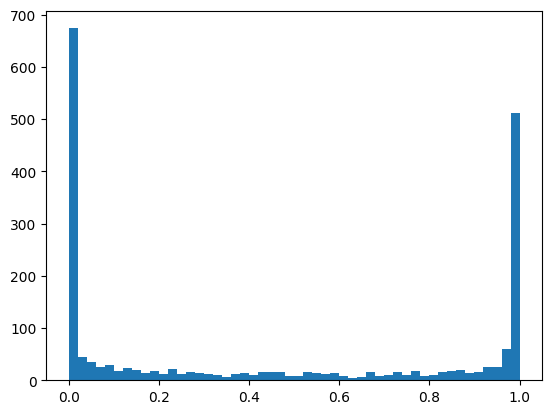

In [97]:
plt.hist(noisy_preds.mean(axis=0), bins=50)
plt.show()

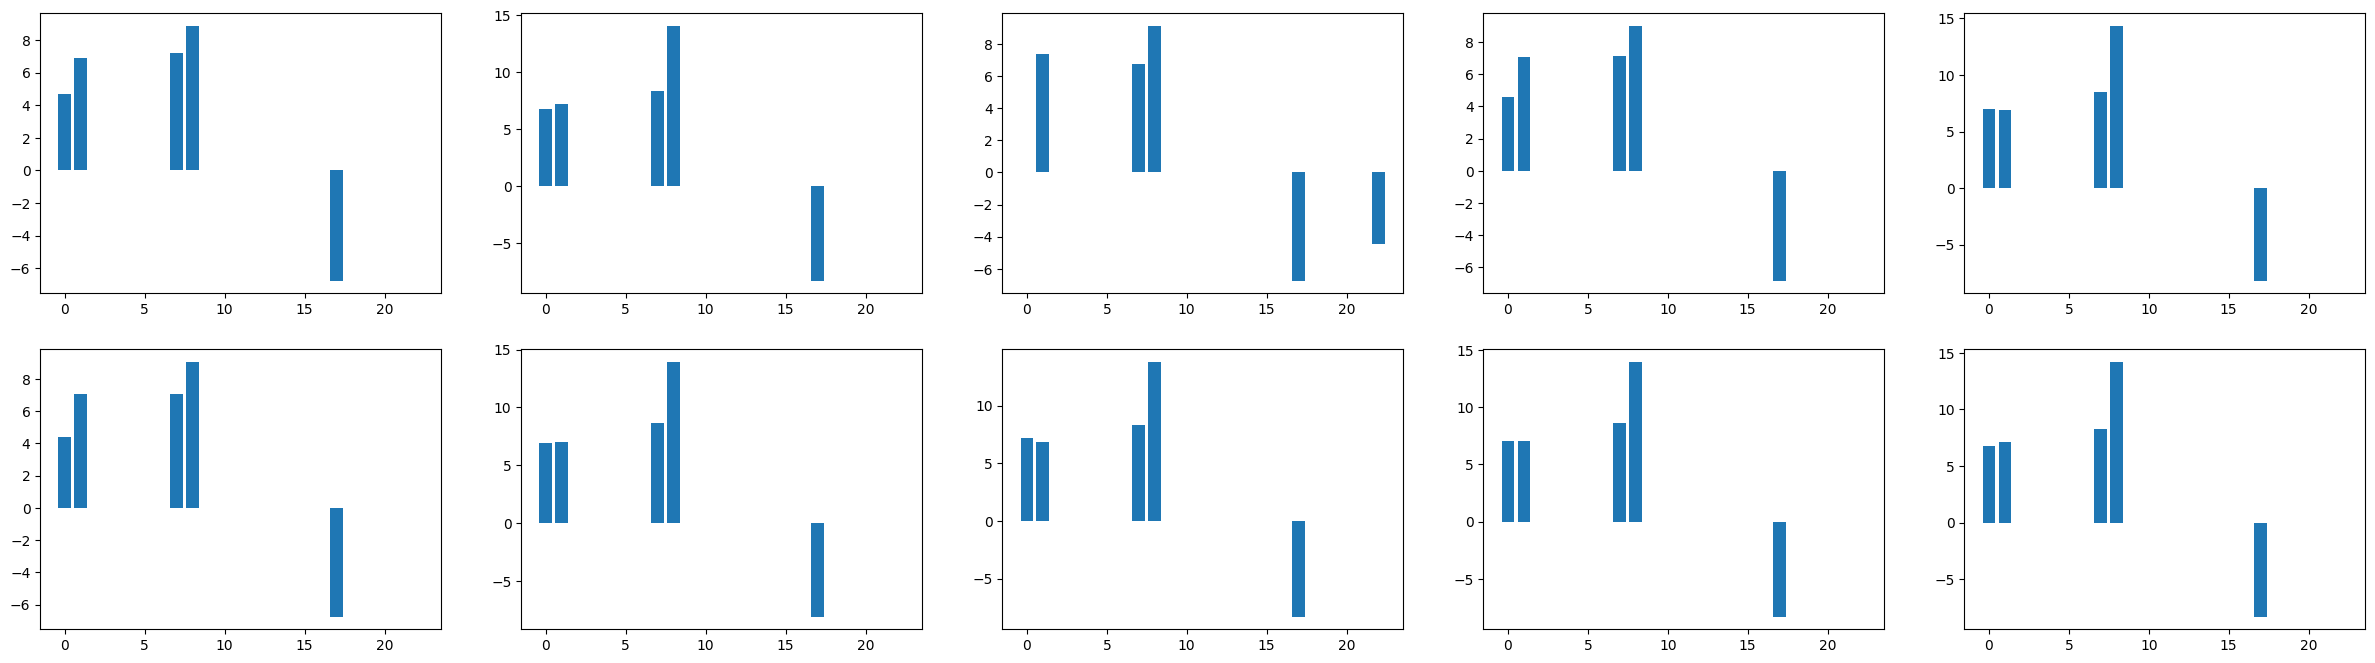

In [59]:
plot_grads(noisy_grads[:10, 2], nrows=2, ncols=5, k=5)

### Multiple Models

In [342]:
ensemble_size = 20
sigma = 0.5
n_samples = 100
model_class = get_model_class(name)
model_idx = np.random.choice(n_models, ensemble_size, replace=False)
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
preds = np.array([np.load(f'{directory}/{random_source}_preds_{idx}.npy') for idx in model_idx])
model_idx

array([127, 131, 190,  73, 964, 569, 333, 466, 177, 164, 275, 729, 954,
       566,  24, 951, 733,  40, 214, 106])

In [343]:
noisy_grads = np.zeros((n_samples, *grads.shape))
noisy_preds = np.zeros((n_samples, *preds.shape))
layer_str = 'network.0.weight'
for j in tqdm(range(len(model_idx))):
    for i in range(n_samples):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx[j]}.pth')
        # Add noise to layer weights
        state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
        model.load_state_dict(state_dict)

        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        noisy_grads[i, j] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        noisy_preds[i, j] = model.predict(X_test, return_numpy=True)

100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


In [344]:
tk, s = get_top_k(5, grads, return_sign=True)
sa = average_pairwise_score(tk, s, top_k_sa)
tk_smooth, s_smooth = get_top_k(5, noisy_grads.mean(axis=0), return_sign=True)
sa_smooth = average_pairwise_score(tk_smooth, s_smooth, top_k_sa)

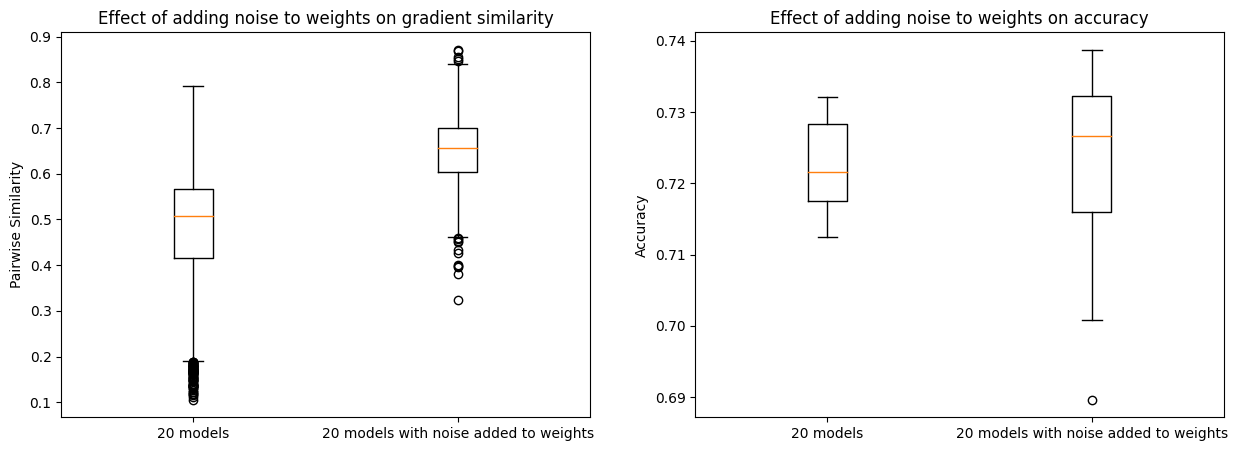

In [345]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].boxplot([sa, sa_smooth], labels=['20 models', '20 models with noise added to weights'])
ax[0].set_title('Effect of adding noise to weights on gradient similarity')
ax[0].set_ylabel('Pairwise Similarity')

smooth_preds = np.where(noisy_preds.mean(axis=0) > 0.5, 1, 0)
smooth_acc = (smooth_preds==y_test).mean(axis=1)
orig_acc = (preds==y_test).mean(axis=1)
ax[1].boxplot([orig_acc, smooth_acc], labels=['20 models', '20 models with noise added to weights'])
ax[1].set_title('Effect of adding noise to weights on accuracy')
ax[1].set_ylabel('Accuracy')

plt.show()

In [353]:
ensemble_preds = np.where(preds.mean(axis=0) > 0.5, 1, 0)
smooth_ensemble_preds = np.where(smooth_preds.mean(axis=0) > 0.5, 1, 0)
(ensemble_preds==y_test).mean(), (smooth_ensemble_preds==y_test).mean()

(0.7296202531645569, 0.7326582278481013)